# Lab Exercise 3: Matched Filters and L-ASK
After studying Chapter 3 and, in particular, Example 3.2 of the notes, copy Code 3.3 of this example into a file named ask_errors.m (the code is repeated here for convenience). Then execute the following:

```{admonition} Live Code
Press the following button to make python code interactive. It will connect you to a kernel once it says "ready" (might take a bit, especially the first time it runs).
```

<div style="text-align: center;">
  <button title="Launch thebe" class="thebelab-button thebe-launch-button" onclick="initThebe()">Python Interactive Code</button>
</div>


#### Importing packages we will need later in Python

In [7]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.signal import convolve
from ipywidgets import Checkbox, VBox, Button, Output

## Part 1: Theory

#### Code 3.3: Calculation of the probability of erroneous symbol for coherent ASK with orthogonal

````` {admonition} Code 3.3
````{tab} Python
```python

import numpy as np

def ask_errors(k, M, nsamp, EbN0_db):
    # L is the number of different amplitude levels (2^k)
    L = 2**k
    # Calculate SNR in dB adjusting for number of samples and bits per symbol
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    # Convert SNR from dB to linear scale
    SNR = 10 ** (SNR_db * 0.1)
    # Generate a vector of random symbols with amplitudes {±1, ±3, ... ±(L-1)}
    x = 2*np.floor(L*np.random.rand(M)) - L + 1
    # Theoretical signal power
    P_x = (L**2-1) / 3
    # Measured signal power (for verification)
    Measured_x = np.sum(x*x)/len(x)

    # Generate oversampled signal y by repeating each symbol nsamp times
    y = []
    for i in range(len(x)):
        for j in range(nsamp):
            y.append(x[i])
    y = np.array(y)

    # Generate noise with zero mean and variance based on the signal power and SNR
    noise = np.random.normal(0, np.sqrt(Measured_x/SNR), len(y))
    # Add noise to the signal
    y_noisy = y + noise

    # Reshape the noisy signal for matched filtering
    y = np.reshape(y_noisy, (M, nsamp))
    # Create a matched filter with coefficients all ones
    matched = np.ones((nsamp, 1))
    # Apply matched filter to the signal
    z = np.matmul(y, matched)
    z = z / nsamp
    # Levels for decision making {±1, ±3, ... ±(L-1)}
    l = np.arange(-L+1, L, 2)

    # Decision making: for each symbol, find the closest amplitude level
    z = z[:, 0]
    for i in range(len(z)):
        differences = np.abs(l - z[i]) # Array of differences from the signal to the levels
        m = min(differences)
        [index], = np.where(differences == m)
        z[i] = l[index]
    
    # Count errors: compare the decided symbols with the original symbols
    errors = 0
    for i in range(len(z)):
        if x[i] != z[i]:
            errors += 1
    
    # Return the total number of symbol errors
    return errors

```
````
````{tab} Matlab
```matlab

function errors=ask_errors(k, Nsymb, nsamp, EbNo)
% This function simulates the generation and decoding
% of a noisy L-ASK signal and counts the number of erroneous symbols.
% It returns the number of erroneous symbols (in the variable errors).
% k is the number of bits/symbol, therefore L=2^k -- the number of
% different amplitudes
% Nsymb is the number of generated symbols (length of LASK sequence)
% nsamp is the number of samples per symbol (oversampling ratio)
% EbNo is the normalized signal-to-noise ratio Eb/No, in dB
%
L=2^k;
SNR=EbNo-10*log10(nsamp/2/k); % SNR per signal sample
% Vector of random integers {±1, ±3, ... ±(L-1)}. To be verified
x=2*floor(L*rand(1, Nsymb))-L+1;
Px=(L^2-1)/3; % theoretical signal power
sum(x.^2)/length(x); % measured signal power (for verification)
y=rectpulse(x, nsamp);
n=wgn(1, length(y), 10*log10(Px)-SNR);
ynoisy=y+n; % noisy signal
y=reshape(ynoisy, nsamp, length(ynoisy)/nsamp);
matched=ones(1, nsamp);
z=matched*y/nsamp;
A=[-L+1:2:L-1];
for i=1:length(z)
    [m, j]=min(abs(A-z(i)));
    z(i)=A(j);
end
err=not(x==z);
errors=sum(err);
end

```
````
`````

## Part 2: Simulation Code Exploration

(a) Modify the code so that the L elements of vector x in line 14 take values from the set {±d/2, ±3d/2, ±5d/2...}, where the distance d of the points will be given as a parameter. Using the value d=5, verify by calculation and displaying a relevant histogram, that the elements of vector x indeed follow a uniform distribution. Use k=mod(nnnnn,2)+3, where nnnnn is the last 5-digit part of your registration number.

Hint: Generate (with command 14) at least 40,000 random integers, and use the command hist(x,A) to calculate and display the histogram, where A is the vector of the L different values of these integers. Modify command 15 appropriately for the theoretical calculation of power and verify with command 16. Similarly, modify command 23 appropriately.

In [8]:
def generate_histogram(k):
    M = 40000
    L = 2 ** k

    x = 2 * np.floor(L * np.random.rand(M)) - L + 1
    bins = np.arange(-L, L + 2, 2)
    A = np.arange(-(L - 1), L, 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.hist(x, bins=bins, edgecolor='white', color='#1F77B4')  # Use ax.hist for compatibility with widgets
    ax.set_xticks(A)
    ax.set_xlabel("Integers")
    ax.set_ylabel("Frequency")
    ax.set_title("Histogram of array x elements")
    plt.show()

k_input = widgets.IntText(
    value=3,  # default value
    description='k:',
    continuous_update=False
)

ui = widgets.VBox([k_input])
out = widgets.interactive_output(generate_histogram, {'k': k_input})

# Display the UI components
display(ui, out)

Output()

(b) With parameter values of the function k=4, M=60000, nsamp=20, and EbNo=12, execute commands 11 to 22 and then plot the histogram of z with the command hist(z,200). Repeat the above for EbNo=16 and EbNo=20. What do you observe? Explain the differences in the three diagrams.

In [9]:
def generate_histogram(k, EbN0_db):
    M = 60000
    nsamp = 16

    L = 2**k
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)
    x = 2*np.floor(L*np.random.rand(M)) - L + 1
    P_x = (L**2 - 1) / 3
    Measured_x = np.sum(x**2)/len(x)

    y = np.repeat(x, nsamp)

    noise = np.random.normal(0, np.sqrt(Measured_x/SNR), len(y))
    y_noisy = y + noise

    y_reshaped = np.reshape(y_noisy, (M, nsamp))
    matched = np.ones((nsamp, 1))
    z = np.matmul(y_reshaped, matched) / nsamp

    A = np.arange(-(L-1), L, 2)  # Adjusted to use inside plotting
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.hist(z, bins=200,  edgecolor='white', color='#1F77B4')
    ax.set_xticks(A)
    ax.set_xlabel("Integers")
    ax.set_ylabel("Frequency")
    ax.legend(["Eb/N0 = " + str(EbN0_db)])
    ax.set_title('Histogram of the Noisy Signal')
    plt.show()

k_input = widgets.IntText(
    value=4,  # default value
    description='k:',
    continuous_update=False
)

EbN0_db_slider = widgets.FloatSlider(
    value=10,  # default value
    min=0,    # minimum value
    max=20,   # maximum value
    step=0.1,   # step size
    description='Eb/N0 (dB):',
    continuous_update=False
)

ui = widgets.VBox([k_input, EbN0_db_slider])

out = widgets.interactive_output(generate_histogram, {'k': k_input, 'EbN0_db': EbN0_db_slider})

# Display the UI components
display(ui, out)

Output()

(c) What does command 20 do and what does command 22 do? What type and dimension are the variables: x in command 14, y in command 17, y in command 20, matched, z, err, and errors?

(d) Explain the operation of the loop 24-27 of Code 3.3 as a minimum distance detector for L-ASK.

## Part 3: Performance Curves (BER as a function of the signal-to-noise ratio)

Verify the curve of Figure 3.10 of the notes (for convenience repeated below) for L-ASK, with L=2k, k=mod(nnnnn, 2)+3, where nnnnn is the last 5-digit part of your registration number. Plot the theoretical curve and superimpose the simulation results (discrete points), as in the figure. 'Read' from the 8-ASK curve and write in the submission file the BER values for Eb/No={8,14,18}db. Conversely, find the appropriate Eb/No value for an 8-ASK system with a transmission rate of R=1Mbps, so that the error rate does not exceed the value {10, 100, 1000} bps.

![lab3_1.png](../content/images/lab3_1.png)

This should be done in two ways:

(a) With your main program, which (i) will plot the curve using equation (3.33) of the notes and the approximation BER≈Pe/log2L, and (ii) will appropriately call the function ask_errors() for calculating the discrete points.

$$
P_e = \frac{L-1}{L} \cdot \text{erfc}\left( \sqrt{\frac{3 \log_2 L  }{L^2 - 1} \cdot \frac{E_{b,av}}{N_o}} \right)
$$

(where Pe is the false symbol probability)

Hint: (a) Call ask_errors(), once for each different value of EbNo, with a sufficiently high value of M (e.g., 20000) and calculate the error rate.

(b) Using the MATLAB BERTOOL tool. The tool is called by typing the bertool command in the MATLAB command window. In the window that appears, you should make the appropriate settings for each case, as indicated in the boxes below. As explained in Example 3.2 of the notes, bertool calls our function, ask_errors(), through the ask_ber_func.m function of code 3.4, in which appropriate values for the parameters k, Nsymb, and nsamp must be set. The files of both functions must be in the current folder (or in a folder that is in the path) of MATLAB.

![lab3_2.png](../content/images/lab3_2.png)

![lab3_3.png](../content/images/lab3_3.png)

````` {admonition} ask_ber_func()
````{tab} Python
```python


def ask_ber_func(EbNo_db, maxNumErrs, maxNumBits):
    # Initialize variables related to exit criteria
    totErr = 0  # Number of errors observed
    numBits = 0  # Number of bits processed

    # Set up parameters
    k = 3  # Number of bits per symbol
    Nsymb = 2000  # Number of symbols in each run
    nsamp = 16  # Oversampling, i.e., number of samples per T
    EbNo = 10 ** (EbNo_db / 10)  # Convert EbNo from dB to linear scale

    # Simulate until the number of errors exceeds maxNumErrs
    # or the number of bits processed exceeds maxNumBits
    while (totErr < maxNumErrs) and (numBits < maxNumBits):
        errors = ask_errors(k, Nsymb, nsamp, EbNo)
        # Assume Gray coding: 1 symbol error ==> 1 bit error
        totErr += errors
        numBits += k * Nsymb

    # Compute the BER
    ber = totErr / numBits
    return ber, numBits

```
````
````{tab} Matlab
```matlab

function [ber,numBits] = ask_ber_func(EbNo, maxNumErrs, maxNumBits)
% Import Java class for BERTool.
import com.mathworks.toolbox.comm.BERTool;
% Initialize variables related to exit criteria.
totErr = 0; % Number of errors observed
numBits = 0; % Number of bits processed
% --- Set up parameters. ---
% --- INSERT YOUR CODE HERE.
k=3; % number of bits per symbol
Nsymb=2000; % number of symbols in each run
nsamp=16; % oversampling,i.e. number of samples per T
% Simulate until number of errors exceeds maxNumErrs
% or number of bits processed exceeds maxNumBits.
while((totErr < maxNumErrs) && (numBits < maxNumBits))
% Check if the user clicked the Stop button of BERTool.
if (BERTool.getSimulationStop)
break;
end
% Β. --- INSERT YOUR CODE HERE.
errors=ask_errors(k,Nsymb,nsamp,EbNo);
% Assume Gray coding: 1 symbol error ==> 1 bit error
totErr=totErr+errors;
numBits=numBits + k*Nsymb;
end % End of loop
% Compute the BER
ber = totErr/numBits;


```
````
`````




In [14]:
def ask_errors(k,M,nsamp,EbN0_db):
    
    L = 2**k
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)
    x = 2*np.floor(L*np.random.rand(M)) - L + 1
    P_x = (L*L-1) / 3
    Measured_x = np.sum(x*x)/len(x)

    y = []
    for i in range(len(x)):
        for j in range(nsamp):
            y.append(x[i])
    y = np.array(y)

    noise = np.random.normal(0, np.sqrt(Measured_x/SNR),len(y))
    y_noisy = y + noise

    y = np.reshape(y_noisy, (M, nsamp))
    matched = np.ones((nsamp,1))
    z = np.matmul(y, matched)
    z = z / nsamp
    l = np.arange(-L+1,L,2)

    z = z[:,0]
    for i in range(len(z)):
        differences = np.abs(l-z[i]) # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        m = min(differences)
        [index], = np.where(differences == m)
        z[i] = l[index]
    
    errors = 0
    for i in range(len(z)):
        if x[i] != z[i]:
            errors += 1
    
    return errors


M = 20000
nsamp = 16
EbN0_db = np.arange(0, 16, 1)
EbN0 = 10**(EbN0_db / 10)

# Create checkboxes for each modulation level
checkbox_4qam = Checkbox(value=True, description='4-QAM')
checkbox_8qam = Checkbox(value=False, description='8-QAM')
checkbox_16qam = Checkbox(value=False, description='16-QAM')

plot_output = Output()

def plot_selected_modulations(btn=None):
    with plot_output:
        clear_output(wait=True)
        plt.figure(figsize=(10, 7))
        
        # Define colors for each modulation level
        colors = {
            '4-QAM': ('red', 'tomato'),
            '8-QAM': ('green', 'limegreen'),
            '16-QAM': ('blue', 'dodgerblue')
        }
        
        for i, (k, checkbox) in enumerate(zip([2, 3, 4], [checkbox_4qam, checkbox_8qam, checkbox_16qam])):
            if checkbox.value:
                L = 2**k
                modulation_name = f'{L}-QAM'
                ber = np.zeros(len(EbN0_db))
                for index, eb_n0 in enumerate(EbN0_db):
                    # Simulate experimental BER using a placeholder function
                    ber[index] = ask_errors(k, M, nsamp, index) / M / np.log2(L)
                
                # Plot experimental BER as points without connecting lines, using specific colors
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=colors[modulation_name][0])
                
                # Theoretical BER for comparison, with distinct line color
                ber_theoretical = (((L-1)/L) * erfc(np.sqrt(EbN0 * (3 * np.log2(L)) / (L**2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=colors[modulation_name][1])

        plt.grid(True, which='both')
        plt.xlabel("Eb/N0 (dB)")
        plt.ylabel("BER")
        plt.legend()
        plt.show()

# Button to update the plot
plot_button = Button(description="Plot")
plot_button.on_click(plot_selected_modulations)

# Initially plot with default settings
plot_selected_modulations()

# Displaying the widgets and the output container
display(VBox([checkbox_4qam, checkbox_8qam, checkbox_16qam, plot_button]), plot_output)

Output()

## Part 4: Implementation with Convolution - Using Other Pulses

Replace command 17 of Code 3.3 with the following commands

`````{tab} Python
````python

h=ones(1,nsamp); h=h/sqrt(h*h'); % filter impulse response
% sender side (orthogonal pulse of energy equal to one)
y=upsample(x,nsamp); % upsampling
y=conv(y,h); % convolution of signal
y=y(1:M*nsamp); % cutting the last elements of convolution

````
`````
`````{tab} Matlab
````matlab

h=ones(1,nsamp); h=h/sqrt(h*h'); % filter impulse response
% transmitter (rectangular pulse of unit energy)
y=upsample(x,nsamp); % conversion to the dense grid
y=conv(y,h); % the signal to be transmitted
y=y(1:M*nsamp); % tail left by the convolution is truncated

````
`````

Also, the noisy signal, ynoisy, should be produced with the command:

`````{tab} Python
````python

ynoisy=awgn(y,SNR,'measured'); % noisy signal


# Assuming y (signal) and SNR (signal-to-noise ratio in dB) are defined
# Example: SNR = 10
y_noisy = add_awgn_noise(y, SNR)

````
`````
`````{tab} Matlab
````matlab

ynoisy=awgn(y,SNR,'measured'); % noisy signal

````
`````

and the matched filter (commands 21,22) to be implemented with convolution as:

`````{tab} Python
````python

for i=1:nsamp matched(i)=h(end-i+1); end
yrx=conv(ynoisy,matched);
z = yrx(nsamp:nsamp:M*nsamp);

````
`````
`````{tab} Matlab
````matlab

for i=1:nsamp matched(i)=h(end-i+1); end
yrx=conv(ynoisy,matched);
z = yrx(nsamp:nsamp:M*nsamp);

````
`````

(the command that does reshape on the ynoisy signal must, of course, be abolished here).

````` {admonition} New Code 3.3
````{tab} Python
```python

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.stats import norm
from scipy.signal import convolve

def ask_errors_new(k, M, nsamp, EbN0_db):
    L = 2**k
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    SNR_linear = 10 ** (SNR_db / 10)
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Create the filter impulse response
    h = np.ones(nsamp) / np.sqrt(nsamp)

    # Sender side: upsample and then convolve (filter) the signal
    y = upfirdn(h, x, up=nsamp)
    y = y[:M * nsamp]  # Cutting the last elements of convolution if any

    # Add noise to the signal. We calculate noise variance from SNR
    P_x = np.mean(y ** 2)  # Signal power
    noise_variance = P_x / SNR_linear
    noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
    y_noisy = y + noise

    # Receiver side: matched filtering
    matched = h[::-1]  # Matched filter is a time-reversed version of h
    yrx = convolve(y_noisy, matched, mode='full')
    z = yrx[nsamp - 1:M * nsamp:nsamp]  # Sampling at symbol rate after matched filtering

    # Decision device
    levels = np.arange(-L + 1, L, 2)
    z_decided = levels[np.abs(levels[:, None] - z).argmin(axis=0)]

    # Count the errors
    errors = np.count_nonzero(x != z_decided)
    
    return errors

```
````
````{tab} Matlab
```matlab

function errors=ask_errors(k, Nsymb, nsamp, EbNo)
% This function simulates the generation and decoding
% of a noisy L-ASK signal and counts the number of erroneous symbols.
% It returns the number of erroneous symbols (in the variable errors).
% k is the number of bits/symbol, therefore L=2^k -- the number of
% different amplitudes
% Nsymb is the number of generated symbols (length of LASK sequence)
% nsamp is the number of samples per symbol (oversampling ratio)
% EbNo is the normalized signal-to-noise ratio Eb/No, in dB
%
L=2^k;
SNR=EbNo-10*log10(nsamp/2/k); % SNR per signal sample
% Vector of random integers {±1, ±3, ... ±(L-1)}. To be verified
x=2*floor(L*rand(1, Nsymb))-L+1;
Px=(L^2-1)/3; % theoretical signal power
sum(x.^2)/length(x); % measured signal power (for verification)
h=ones(1,nsamp); h=h/sqrt(h*h'); % filter impulse response
% transmitter (rectangular pulse of unit energy)
y=upsample(x,nsamp); % conversion to the dense grid
y=conv(y,h); % the signal to be transmitted
y=y(1:M*nsamp); % tail left by the convolution is truncated
n=wgn(1, length(y), 10*log10(Px)-SNR);
ynoisy=awgn(y,SNR,'measured'); % noisy signal
for i=1:nsamp matched(i)=h(end-i+1); end
yrx=conv(ynoisy,matched);
z = yrx(nsamp:nsamp:M*nsamp);
A=[-L+1:2:L-1];
for i=1:length(z)
    [m, j]=min(abs(A-z(i)));
    z(i)=A(j);
end
err=not(x==z);
errors=sum(err);
end

```
````
`````

(a) Confirm that the modified code produces the same results as Code 3.3.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.signal import upfirdn, convolve
from ipywidgets import Checkbox, Button, Output, VBox, HBox, Dropdown
from IPython.display import clear_output

def ask_errors_new(k, M, nsamp, EbN0_db):
    L = 2**k
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    SNR_linear = 10 ** (SNR_db / 10)
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Create the filter impulse response
    h = np.ones(nsamp) / np.sqrt(nsamp)

    # Sender side: upsample and then convolve (filter) the signal
    y = upfirdn(h, x, up=nsamp)
    y = y[:M * nsamp]  # Cutting the last elements of convolution if any

    # Add noise to the signal. We calculate noise variance from SNR
    P_x = np.mean(y ** 2)  # Signal power
    noise_variance = P_x / SNR_linear
    noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
    y_noisy = y + noise

    # Receiver side: matched filtering
    matched = h[::-1]  # Matched filter is a time-reversed version of h
    yrx = convolve(y_noisy, matched, mode='full')
    z = yrx[nsamp - 1:M * nsamp:nsamp]  # Sampling at symbol rate after matched filtering

    # Decision device
    levels = np.arange(-L + 1, L, 2)
    z_decided = levels[np.abs(levels[:, None] - z).argmin(axis=0)]

    # Count the errors
    errors = np.count_nonzero(x != z_decided)
    
    return errors



M = 20000
EbN0_db = np.arange(0, 16, 1)

# Initialize the widgets
checkbox_4qam = Checkbox(value=True, description='4-QAM')
checkbox_8qam = Checkbox(value=False, description='8-QAM')
checkbox_16qam = Checkbox(value=False, description='16-QAM')
nsamp_dropdown = Dropdown(options=[4, 8, 16, 32, 64], value=16, description='Samples per Symbol:', style={'description_width': 'initial'})

plot_output = Output()

def plot_selected_modulations(btn=None):
    with plot_output:
        clear_output(wait=True)
        nsamp = nsamp_dropdown.value  # Get the selected value from the dropdown
        plt.figure(figsize=(10, 7))
        
        # Define colors for each modulation level
        colors = {
            '4-QAM': 'red',
            '8-QAM': 'green',
            '16-QAM': 'blue'
        }
        
        for k, checkbox, color in zip([2, 3, 4], [checkbox_4qam, checkbox_8qam, checkbox_16qam], colors.values()):
            if checkbox.value:
                L = 2**k
                modulation_name = f'{L}-QAM'
                ber = np.zeros(len(EbN0_db))
                for index, eb_n0 in enumerate(EbN0_db):
                    # Simulate experimental BER
                    ber[index] = ask_errors_new(k, M, nsamp, eb_n0) / (M * np.log2(L))
                
                # Plot experimental BER
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=color)
                
                # Theoretical BER for comparison
                ber_theoretical = (((L-1)/L) * erfc(np.sqrt(10**(EbN0_db / 10) * (3 * np.log2(L)) / (L**2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=color)
        
        plt.grid(True, which='both')
        plt.xlabel("Eb/N0 (dB)")
        plt.ylabel("BER")
        plt.legend()
        plt.show()

# Button to update the plot based on the selected nsamp
plot_button = Button(description="Plot")
plot_button.on_click(plot_selected_modulations)

# Display the widgets and the output container
display(HBox([nsamp_dropdown]), VBox([checkbox_4qam, checkbox_8qam, checkbox_16qam, plot_button]), plot_output)

# Call the function initially to display the plot
plot_selected_modulations()

Output()

(b) After executing the body of the modified function ask_errors() without adding noise (i.e., with ynoisy=y), plot a section of the signals x, y, and yrx.

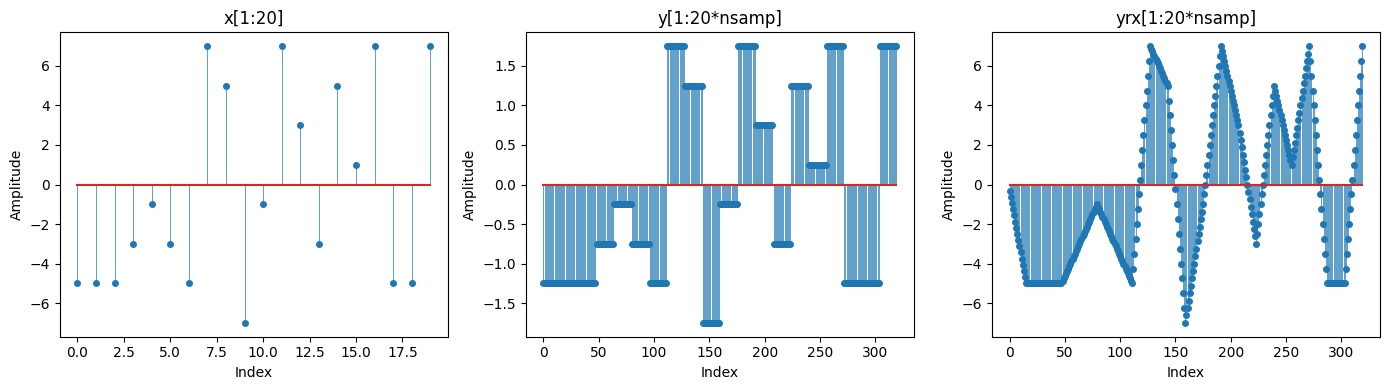

In [35]:
import numpy as np
from scipy.signal import upfirdn, convolve

def ask_errors_modified(k, M, nsamp, add_noise=False):
    L = 2**k
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Create the filter impulse response
    h = np.ones(nsamp) / np.sqrt(nsamp)

    # Sender side: upsample and then convolve (filter) the signal
    y = upfirdn(h, x, up=nsamp)
    y = y[:M * nsamp]  # Cutting the last elements of convolution if any

    # Optionally add noise
    y_noisy = y
    if add_noise:
        SNR_db = 10  # Example SNR value, adjust as necessary
        SNR_linear = 10 ** (SNR_db / 10)
        P_x = np.mean(y ** 2)  # Signal power
        noise_variance = P_x / SNR_linear
        noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
        y_noisy = y + noise

    # Receiver side: matched filtering
    matched = h[::-1]  # Matched filter is a time-reversed version of h
    yrx = convolve(y_noisy, matched, mode='full')
    yrx = yrx[:M * nsamp]  # Adjust length to match y

    # Returning slices for visualization
    return x[:20], y[:20*nsamp], yrx[:20*nsamp]


import matplotlib.pyplot as plt

# Get the signal parts
x_part, y_part, yrx_part = ask_errors_modified(k, M, nsamp, add_noise=False)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Plot x
markerline, stemlines, baseline = axs[0].stem(x_part)
plt.setp(stemlines, 'linewidth', 0.5)  # Set the stem lines' width
plt.setp(markerline, 'markersize', 4)  # Set the marker size
axs[0].set_title('x[1:20]')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Amplitude')

# Plot y
markerline, stemlines, baseline = axs[1].stem(y_part)
plt.setp(stemlines, 'linewidth', 0.5)  # Set the stem lines' width
plt.setp(markerline, 'markersize', 4)  # Set the marker size
axs[1].set_title('y[1:20*nsamp]')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Amplitude')

# Plot yrx
markerline, stemlines, baseline = axs[2].stem(yrx_part)
plt.setp(stemlines, 'linewidth', 0.5)  # Set the stem lines' width
plt.setp(markerline, 'markersize', 4)  # Set the marker size
axs[2].set_title('yrx[1:20*nsamp]')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Amplitude')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


Write a brief explanation of the second and third diagrams.

(c) Replace the rectangular pulse h with another, e.g., a cosine of one period: 
$$
h=cos(2*pi*(1:nsamp)/nsamp); h=h/sqrt(h*h’);
$$

Execute the simulation again with bertool. What is the conclusion about the performance of the new L-ASK system? If we revert the command matched=h for the matched filter, we will observe that we do not get correct results, especially for small values of nsamp (e.g., nsamp=8). Explain this, after observing the shape of the pulse h in the two cases (rectangular pulse and sine pulse), plotting it with stems (stem(h)). Repeat the experiment for nsamp=32 and 64.

In [37]:
import numpy as np
from scipy.signal import convolve, upfirdn

def ask_errors_sin(k, M, nsamp, EbN0_db):
    L = 2**k
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    SNR_linear = 10 ** (SNR_db / 10)
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Create the sinusoidal filter impulse response
    h = np.cos(2 * np.pi * np.arange(1, nsamp + 1) / nsamp)
    h = h / np.sqrt(np.dot(h, h.T))

    # Sender side: upsample and then convolve (filter) the signal
    y = upfirdn(h, x, up=nsamp)
    y = y[:M * nsamp]  # Cutting the last elements of convolution if any

    # Add noise to the signal. We calculate noise variance from SNR
    P_x = np.mean(y ** 2)  # Signal power
    noise_variance = P_x / SNR_linear
    noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
    y_noisy = y + noise

    # Receiver side: matched filtering
    matched = h[::-1]  # Matched filter is a time-reversed version of h
    yrx = convolve(y_noisy, matched, mode='full')
    z = yrx[nsamp - 1:M * nsamp:nsamp]  # Sampling at symbol rate after matched filtering

    # Decision device
    levels = np.arange(-L + 1, L, 2)
    z_decided = levels[np.abs(levels[:, None] - z).argmin(axis=0)]

    # Count the errors
    errors = np.count_nonzero(x != z_decided)
    
    return errors




M = 20000
EbN0_db = np.arange(0, 16, 1)

# Initialize the widgets
checkbox_4qam3 = Checkbox(value=True, description='4-QAM')
checkbox_8qam3 = Checkbox(value=False, description='8-QAM')
checkbox_16qam3 = Checkbox(value=False, description='16-QAM')
nsamp_dropdown3 = Dropdown(options=[4, 8, 16, 32, 64], value=16, description='Samples per Symbol:', style={'description_width': 'initial'})

plot_output3 = Output()

def plot_selected_modulations3(btn=None):
    with plot_output3:
        clear_output(wait=True)
        nsamp = nsamp_dropdown3.value  # Get the selected value from the dropdown
        plt.figure(figsize=(10, 7))
        
        # Define colors for each modulation level
        colors = {
            '4-QAM': 'red',
            '8-QAM': 'green',
            '16-QAM': 'blue'
        }
        
        for k, checkbox, color in zip([2, 3, 4], [checkbox_4qam3, checkbox_8qam3, checkbox_16qam3], colors.values()):
            if checkbox.value:
                L = 2**k
                modulation_name = f'{L}-QAM'
                ber = np.zeros(len(EbN0_db))
                for index, eb_n0 in enumerate(EbN0_db):
                    # Simulate experimental BER
                    ber[index] = ask_errors_sin(k, M, nsamp, eb_n0) / (M * np.log2(L))
                
                # Plot experimental BER
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=color)
                
                # Theoretical BER for comparison
                ber_theoretical = (((L-1)/L) * erfc(np.sqrt(10**(EbN0_db / 10) * (3 * np.log2(L)) / (L**2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=color)
        
        plt.grid(True, which='both')
        plt.xlabel("Eb/N0 (dB)")
        plt.ylabel("BER")
        plt.legend()
        plt.show()

# Button to update the plot based on the selected nsamp
plot_button3 = Button(description="Plot")
plot_button3.on_click(plot_selected_modulations3)

# Display the widgets and the output container
display(HBox([nsamp_dropdown3]), VBox([checkbox_4qam3, checkbox_8qam3, checkbox_16qam3, plot_button3]), plot_output3)



# Call the function initially to display the plot
plot_selected_modulations3()

Output()